## Cooking with ClarityNLP - Session #3

The goal of this series is to introduce you to writing basic queries using NLPQL. Today we will also be covering an introduction to iterative data exploration and feature engineering for a given cohort using unsupervised learning techniques. For details on installing and using ClarityNLP, please see our [documentation](https://claritynlp.readthedocs.io/en/latest/index.html).  We welcome questions during this presentation, as well as via Slack or on [GitHub](https://github.com/ClarityNLP/ClarityNLP/issues).

If you're running ClarityNLP locally via Docker, make sure that the Docker swarm is up and running before following along:
- See https://claritynlp.readthedocs.io/en/latest/setup/local-docker.html#running-locally.

In [55]:
# Import dependencies

# !pip3 install --user `package_name` #if you need to install a dependency rather than import it
%matplotlib inline
import pandas as pd
pd.set_option('display.width',100000)
pd.set_option('max_colwidth',4000)
import requests
from collections import OrderedDict
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import spacy
import textacy
from textacy import datasets, io, corpus, similarity
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import claritynlp_notebook_helpers as claritynlp

### Session Outline
- Review data ingestion steps.
- Briefly discuss a few phenotype and/or set membership problems that we hope to use unstructured text for to both mine the data, as well as to potentially expand our set of inclusion criteria, and/or identify clusters within our -identified set.
- Construct a foundational NLPQL query to extract a first set of notes for each phenotype.
- Show how to view commonly occuring n-grams on these notes.
- Show how to conduct topic modeling on these notes; walk through return options and how to use them.
- Show how topic vector terms can be fed back into the pipeline to expand the termset.
- Show how topic assignment can be visualized alongside other features extracted from structured text.

### 1. Review of data ingestion

To get started with exploratory data analysis, make sure ClarityNLP is setup and loaded with documents. For a few helpful links see the following:

* [ClarityNLP Documentation](https://clarity-nlp.readthedocs.io/en/latest/)
* [Cooking Sessions 1 and 2](https://github.com/ClarityNLP/ClarityNLP/wiki/Cooking-with-ClarityNLP)

### 2. Select a few concepts that we would like to explore and use for phenotype development

In this example, we explore how we can leverage unstructured clinical notes and ClarityNLP to explore a handful of clinically relevant set membership problems for the purpose of feature engineering and/or patient inclusion/exclusion from a cohort of interest. This can be thought of as a step away from rule-based/heuristic patient identification, and toward computational phenotype development. The techniques reviewed here can be particularly useful in situations where the set/term in question cannot be easily derived from structured data alone, and/or when the set/term in question is difficult to quantify or is unlikely to explicitly appear in structured data. Examples include but are by no means limited to: {`poor social support`; `homelessness`; `substance abuse`; `socioeconomic status`; `financial distress`; `domestic abuse`; `insomnia`; `poor medication compliance`; etc.}.

These topics represent important **socioeconomic** and **behavioral determinants of health** and may also effect eligibility for participation in clinical trials, but are difficult for clinical researchers to detect without manual chart review and/or other types of resource-intensive interventions. 

In the sections that follow, we'll walk through ways in which NLP techniques can help address this problem. It is important to note that these steps represent an **iterative, human-in-the-loop process**, rather than a one-step solution. 

We can begin by aggregating our existing clinical and contextual knowledge of each topic/concept, and using this knowledge to develop a baseline NLPQL query. It is not necessarily important at this stage that our list of terms and/or constraints be exhaustive, as our initial goal is to explore the possible universe of patients. we can return to this step in an iterative fashion, and impose more specific criteria as we go. 

For the purpose of today's discussion, we'll consider three different set membership problems: (1) homelessness; (2) insomnia/trouble sleeping; (3) poor medication compliance. For each of these three set membership questions, we're hoping to understand whether a given patient might currently be experiencing the condition, or has experienced the condition in the past (to the extent that their historical data is present in the system).

We can start by brainstorming a list of terms that we might expect to appear in instances where patients have experienced or are currently experiencing each of our target conditions. Note that we're intentionally trying to cast a wide net at this early stage; we can also use termset expansion and/or lemmatization to handle synonyms and/or similar words represented as different parts of speech. 

#### 2.1: Homelessness 

- homeless
- shelter
- exposure
- frostbite
- lack of access to care
- eviction
- evicted

#### 2.2: Insomnia/Trouble Sleeping 

- insomnia
- poor sleep
- sleep apnea
- tired
- restless leg syndrome
- daytime fatigue
- low energy

#### 2.3 Poor Medication Compliance
- compliance
- adherence
- expensive
- afford

As we covered in previous Cooking sessions, you can use the **term expander** to add additional terms to your query. Let's run the term expander and see if we retrieve any additional terms.

In [2]:
terms_nlpql = '''

termset HomelessTerms:
[
    Synonyms("homeless"),
    Synonyms("shelter"),
    Synonyms("exposure"),
    Synonyms("frostbite"),
    "lack of access to care",
    VerbInflections("evicted"),
    Synonyms("eviction")
];

termset InsomniaTerms:
[
    OHDSI.Synonyms("insomnia"),
    "poor sleep",
    OHDSI.Synonyms("sleep apnea"),
    Synonyms("tired"),
    OHDSI.Synonyms("restless leg syndrome"),
    "RLS",
    "daytime fatigue",
    Synonyms("fatigue"),
    "low energy"
];

termset PoorComplianceTerms:
[

    Synonyms("compliance"),
    Synonyms("adherence"),
    Synonyms("expensive"),
    VerbInflections("afford")];

'''

expanded_nlpql = claritynlp.run_term_expansion(terms_nlpql)
print(expanded_nlpql)



termset HomelessTerms:
[
    "dispossessed","homeless","homeless person","roofless","stateless",
    "protection","shelter","tax shelter",
    "exposure","photo","photograph","pic","picture","vulnerability",
    "cryopathy","frostbite",
    "lack of access to care",
    "evict","evicted","evicting","evicts",
    "constructive eviction","dispossession","eviction","legal ouster"
];

termset InsomniaTerms:
[
    "insomnia","insomnia (disorder)","sleeplessness",
    "poor sleep",
    "sas - sleep apnea syndrome","sas - sleep apnoea syndrome","sleep apnea","sleep apnea (disorder)","sleep apnea (finding)","sleep apnea syndrome","sleep apneic","sleep apnoea","sleep apnoea syndrome","sleep apnoeic","sleep has stopped breathing","sleep hypopnea","sleep hypopnoea","sleep not breathing","sleep, apnea (finding) (observable entity) apnea","sleep, apnea (finding) apnea","sleep, apneic (observable entity) apnea","sleep, apneic apnea","sleep, apnoea (observable entity) apnea","sleep, apnoea apnea","

### 3. Develop and run a foundational NLPQL query for each phenotype we're interested in exploring.

We can use the lists we developed above to develop a foundational NLPQL query for each phenotype. The list of terms returned from the **term expander** will typically be too large for us to use as-is; for the purpose of today's session, we've manually pruned the term list for each phenotype. In the future, we may incorporate quantitative approaches to such pruning using information theoretic metrics.

Running these queries will tell us which patients meet our initial criteria for each phenotype, and we can then perform topic modeling on the notes associated with these patients to help discover additional relevant terms that we can use to either expand or refine our inclusion criteria.

To do this, for each phenotype, we'll use the associated set of terms we've selected to form a ClarityNLP termset. In this way, we're asking ClarityNLP to return the set of notes where at least one of these terms appears (the relationship between the terms is a disjunctive Boolean OR). 

#### 3.1: Homelessness NLPQL

In [3]:
nlpql_homelessness_initial_query = '''

// Phenotype library name
phenotype "Cooking with Clarity Homelessness Initial Set" version "1";

/* Phenotype library description */
description "Sample NLPQL to find notes that may be associated with patients experiencing homelessness; for use in topic modeling.";

// # Structured Data Model #
datamodel OMOP version "5.3";

// # Referenced libraries #
// The ClarityCore library provides common functions for simplifying NLP pipeline creation
include ClarityCore version "1.0" called Clarity;
include OHDSIHelpers version "1.0" called OHDSI;

// ## Code Systems ##
codesystem OMOP: "http://omop.org"; // OMOP vocabulary https://github.com/OHDSI/Vocabulary-v5.0;


// #Manual Term sets#
// simple example-- termset "Vegetables":["brocolli","carrots","cauliflower"]
// can add expansion of structured concepts from terminologies as well with OMOPHelpers

documentset PotentialHomelessnessNotes:
    Clarity.createReportTagList(["Physician","Nurse","Note","Discharge Summary"]);

termset PossibleHomelessness: 
[
    "dispossessed","homeless","homeless person","roofless",
    "shelter",
    "exposure","vulnerability",
    "cryopathy","frostbite",
    "lack of access to care",
    "evict","evicted","evicting","evicts",
    "constructive eviction","dispossession","eviction","legal ouster"];
    

define final isPotentiallyHomeless:
  Clarity.ProviderAssertion({
    termset: [PossibleHomelessness],
    documentset: [PotentialHomelessnessNotes]
  });  
'''

run_result_homeless, main_csv_homeless, intermediate_csv_homeless, luigi_homeless = claritynlp.run_nlpql(nlpql_homelessness_initial_query)

Job Successfully Submitted
{
    "intermediate_results_csv": "http://18.220.133.76:5000/job_results/501/phenotype_intermediate",
    "job_id": "501",
    "luigi_task_monitoring": "http://18.220.133.76:8082/static/visualiser/index.html#search__search=job=501",
    "main_results_csv": "http://18.220.133.76:5000/job_results/501/phenotype",
    "phenotype_config": "http://18.220.133.76:5000/phenotype_id/501",
    "phenotype_id": "501",
    "pipeline_configs": [
        "http://18.220.133.76:5000/pipeline_id/699"
    ],
    "pipeline_ids": [
        699
    ],
    "results_viewer": "?job=501",
    "status_endpoint": "http://18.220.133.76:5000/status/501"
}


#### 3.2: Insomnia/Trouble Sleeping NLPQL

In [4]:
nlpql_insomnia_initial_query = '''

// Phenotype library name
phenotype "Cooking with Clarity Insomnia Initial Set" version "1";

/* Phenotype library description */
description "Sample NLPQL to find notes that may be associated with patients experiencing insomnia; for use in topic modeling.";

// # Structured Data Model #
datamodel OMOP version "5.3";

// # Referenced libraries #
// The ClarityCore library provides common functions for simplifying NLP pipeline creation
include ClarityCore version "1.0" called Clarity;
include OHDSIHelpers version "1.0" called OHDSI;

// ## Code Systems ##
codesystem OMOP: "http://omop.org"; // OMOP vocabulary https://github.com/OHDSI/Vocabulary-v5.0;


// #Manual Term sets#
// simple example-- termset "Vegetables":["brocolli","carrots","cauliflower"]
// can add expansion of structured concepts from terminologies as well with OMOPHelpers

documentset PotentialInsomniaNotes:
    Clarity.createReportTagList(["Physician","Nurse","Note","Discharge Summary"]);
    
termset PossibleInsomnia: 
[
    "insomnia","sleeplessness",
    "poor sleep",
    "sas - sleep apnea syndrome","sleep apnea","sleep apnea syndrome",
    "sleep apneic","sleep apnoea","sleep apnoea syndrome","sleep apnoeic","sleep has stopped breathing",
    "sleep hypopnea","sleep hypopnoea","sleep not breathing","sleeping apnea",
    "sleeping apneic","sleeping apnoea","sleeping apnoeic",
    "tired",
    "restless leg syndrome",
    "RLS",
    "daytime fatigue",
    "fatigue","tiredness","weariness",
    "low energy"
];

define final isPotentiallyInsomnia:
  Clarity.ProviderAssertion({
    termset: [PossibleInsomnia],
    documentset: [PotentialInsomniaNotes]
});
  
'''

run_result_insomnia, main_csv_insomnia, intermediate_csv_insomnia, luigi_insomnia = claritynlp.run_nlpql(nlpql_insomnia_initial_query)

Job Successfully Submitted
{
    "intermediate_results_csv": "http://18.220.133.76:5000/job_results/502/phenotype_intermediate",
    "job_id": "502",
    "luigi_task_monitoring": "http://18.220.133.76:8082/static/visualiser/index.html#search__search=job=502",
    "main_results_csv": "http://18.220.133.76:5000/job_results/502/phenotype",
    "phenotype_config": "http://18.220.133.76:5000/phenotype_id/502",
    "phenotype_id": "502",
    "pipeline_configs": [
        "http://18.220.133.76:5000/pipeline_id/700"
    ],
    "pipeline_ids": [
        700
    ],
    "results_viewer": "?job=502",
    "status_endpoint": "http://18.220.133.76:5000/status/502"
}


#### 3.3 Poor Medication Compliance NLPQL

In [5]:
nlpql_poor_compliance_initial_query = '''


// Phenotype library name
phenotype "Cooking with Clarity Poor Medication Compliance Initial Set" version "1";

/* Phenotype library description */
description "Sample NLPQL to find notes that may be associated with patients experiencing/exhibiting poor medication compliance; for use in topic modeling.";

// # Structured Data Model #
datamodel OMOP version "5.3";

// # Referenced libraries #
// The ClarityCore library provides common functions for simplifying NLP pipeline creation
include ClarityCore version "1.0" called Clarity;
include OHDSIHelpers version "1.0" called OHDSI;

// ## Code Systems ##
codesystem OMOP: "http://omop.org"; // OMOP vocabulary https://github.com/OHDSI/Vocabulary-v5.0;


// #Manual Term sets#
// simple example-- termset "Vegetables":["brocolli","carrots","cauliflower"]
// can add expansion of structured concepts from terminologies as well with OMOPHelpers

documentset PotentialPoorComplianceNotes:
    Clarity.createReportTagList(["Physician","Nurse","Note","Discharge Summary"]);
    
termset PossiblePoorCompliance: 
[
    "abidance","complaisance","compliance","compliancy",
    "adherence",
    "expensive",
    "afford","afforded","affording","affords"];

define final isPotentiallyPoorCompliance:
  Clarity.ProviderAssertion({
    termset: [PossiblePoorCompliance],
    documentset: [PotentialPoorComplianceNotes]
  });

'''

run_result_poor_compliance, main_csv_poor_compliance, intermediate_csv_poor_compliance, luigi_poor_compliance, = claritynlp.run_nlpql(nlpql_poor_compliance_initial_query)

Job Successfully Submitted
{
    "intermediate_results_csv": "http://18.220.133.76:5000/job_results/503/phenotype_intermediate",
    "job_id": "503",
    "luigi_task_monitoring": "http://18.220.133.76:8082/static/visualiser/index.html#search__search=job=503",
    "main_results_csv": "http://18.220.133.76:5000/job_results/503/phenotype",
    "phenotype_config": "http://18.220.133.76:5000/phenotype_id/503",
    "phenotype_id": "503",
    "pipeline_configs": [
        "http://18.220.133.76:5000/pipeline_id/701"
    ],
    "pipeline_ids": [
        701
    ],
    "results_viewer": "?job=503",
    "status_endpoint": "http://18.220.133.76:5000/status/503"
}


### 4. View commonly occuring n-grams on the subset of notes returned by our queries

An **n-gram** is a contiguous sequence of *n* items (in this case, words, separated by whitespace). We can use **n-grams** to help us understand which words commonly appear together within the subset of notes that make up the sub-corpus associated with each of our conditions. 

Note that when we run the n-gram functions below, we can do so on the sub-set of notes returned by our initial queries by calling ```Clarity.getJobResults()``` and passing in a `job_id`.

- See: https://clarity-nlp.readthedocs.io/en/latest/api_reference/nlpql/cohort.html for more information on chaining queries in this way.

We can define a helper function to let us visualize the distribution of the most commonly co-occuring terms:

In [6]:
def view_n_gram_terms(df, keyword, min_apperances=2, n=3):
    
    term_sets = [x.split() for x in df['text']]
    terms = [item for sublist in term_sets for item in sublist if item != keyword]
    
    terms_dict = OrderedDict(sorted(((x, terms.count(x)) for x in terms if terms.count(x) >= min_apperances),
                                    key=lambda x: x[1]))

    x = [k for k in terms_dict.keys()]
    y = [v for v in terms_dict.values()]
    
    plt.figure(figsize=(10,5))
    plt.bar(x,y)
    plt.xticks(fontsize=10, rotation='vertical')
    plt.yticks(fontsize=10)
    plt.title("Frequency of co-occuring terms drawn from set of {}-grams associated with keyword: {}".format(n, keyword), fontsize=15)
    plt.show() 

#### 4.1 n-grams on notes of patients potentially experiencing homelessness

In [7]:
homelessness_ngrams_query = '''

 phenotype "potential homelessness ngram" version "1";

 include ClarityCore version "1.0" called Clarity;

 termset HomelessTerms:
    ["homeless"];

  cohort ClarityFoundHomelessPatients:Clarity.getJobResults({
    "context":"patient",
    "job_id": 486
 });

  define homelessnessNgram:
    Clarity.ngram({
      cohort:ClarityFoundHomelessPatients,
      termset:[HomelessTerms], 
      "n": "3",
      "filter_nums": true,
      "filter_stops": true,
      "filter_punct": true,
      "min_freq": 2,
      "lemmas": true,
      "limit_to_termset": true
      });
      
'''

ngrams_result_homelessness, ngrams_main_csv_homeless, ngrams_intermediate_csv_homeless, ngrams_luigi_homeless = claritynlp.run_nlpql(homelessness_ngrams_query)

Job Successfully Submitted
{
    "intermediate_results_csv": "http://18.220.133.76:5000/job_results/504/phenotype_intermediate",
    "job_id": "504",
    "luigi_task_monitoring": "http://18.220.133.76:8082/static/visualiser/index.html#search__search=job=504",
    "main_results_csv": "http://18.220.133.76:5000/job_results/504/phenotype",
    "phenotype_config": "http://18.220.133.76:5000/phenotype_id/504",
    "phenotype_id": "504",
    "pipeline_configs": [
        "http://18.220.133.76:5000/pipeline_id/702"
    ],
    "pipeline_ids": [
        702
    ],
    "results_viewer": "?job=504",
    "status_endpoint": "http://18.220.133.76:5000/status/504"
}


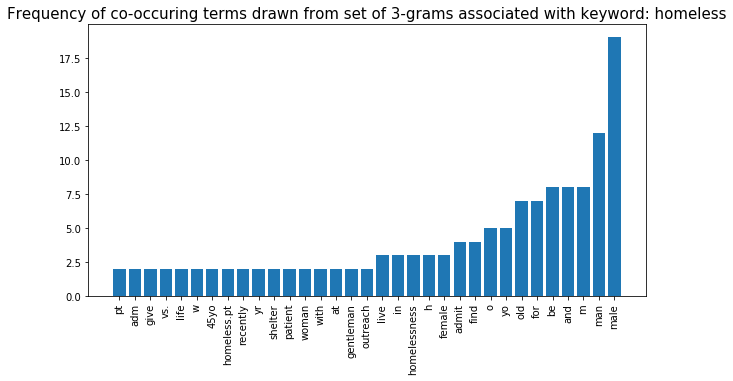

In [11]:
hl_ngrams_df = pd.read_csv(ngrams_result_homelessness['main_results_csv'])
view_n_gram_terms(hl_ngrams_df, "homeless", min_apperances=2, n=3)  

In [8]:
insomnia_ngrams_query = '''

 phenotype "potential insomnia ngram" version "1";

 include ClarityCore version "1.0" called Clarity;

 termset InsomniaTerms:
    ["insomnia"];
    
  cohort ClarityFoundInsomniaPatients:Clarity.getJobResults({
    "context":"patient",
    "job_id": 487
    });

  define insomniaNgram:
    Clarity.ngram({
      termset:[InsomniaTerms], 
      cohort:ClarityFoundInsomniaPatients,
      "n": "3",
      "filter_nums": true,
      "filter_stops": true,
      "filter_punct": true,
      "min_freq": 2,
      "lemmas": true,
      "limit_to_termset": true
      });
      
'''

ngrams_result_insomnia, ngrams_main_csv_insomnia, ngrams_intermediate_csv_insomnia, ngrams_luigi_insomnia = claritynlp.run_nlpql(insomnia_ngrams_query)

Job Successfully Submitted
{
    "intermediate_results_csv": "http://18.220.133.76:5000/job_results/505/phenotype_intermediate",
    "job_id": "505",
    "luigi_task_monitoring": "http://18.220.133.76:8082/static/visualiser/index.html#search__search=job=505",
    "main_results_csv": "http://18.220.133.76:5000/job_results/505/phenotype",
    "phenotype_config": "http://18.220.133.76:5000/phenotype_id/505",
    "phenotype_id": "505",
    "pipeline_configs": [
        "http://18.220.133.76:5000/pipeline_id/703"
    ],
    "pipeline_ids": [
        703
    ],
    "results_viewer": "?job=505",
    "status_endpoint": "http://18.220.133.76:5000/status/505"
}


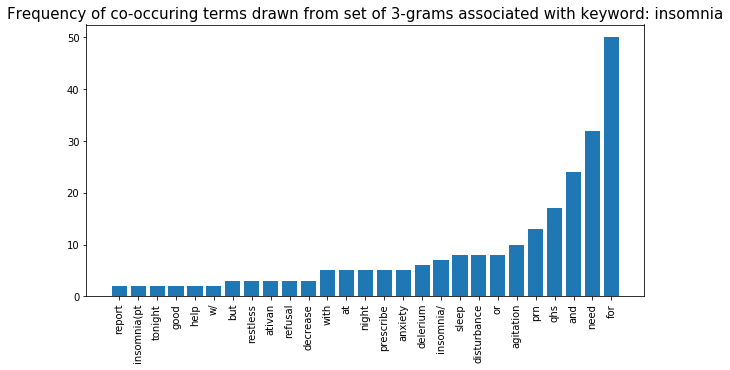

In [25]:
insomnia_ngrams_df = pd.read_csv(ngrams_result_insomnia['intermediate_results_csv'])
view_n_gram_terms(insomnia_ngrams_df, "insomnia", min_apperances=2, n=3)  

In [9]:
poor_compliance_ngrams_query = '''

 phenotype "potential poor medication compliance ngram" version "1";

 include ClarityCore version "1.0" called Clarity;

 termset PoorComplianceTerms:
    ["compliance"];
    
cohort ClarityFoundPoorCompliance:Clarity.getJobResults({
    "context":"patient",
    "job_id": 488
    });

  define poorComplianceNgram:
    Clarity.ngram({
      cohort:ClarityFoundPoorCompliance,
      termset:[PoorComplianceTerms], 
      "n": "3",
      "filter_nums": true,
      "filter_stops": true,
      "filter_punct": true,
      "min_freq": 2,
      "lemmas": true,
      "limit_to_termset": true
      });
      
'''

ngrams_result_poor_compliance, ngrams_main_csv_poor_compliance, ngrams_intermediate_csv_poor_compliance, ngrams_luigi_poor_compliance = claritynlp.run_nlpql(poor_compliance_ngrams_query)

Job Successfully Submitted
{
    "intermediate_results_csv": "http://18.220.133.76:5000/job_results/506/phenotype_intermediate",
    "job_id": "506",
    "luigi_task_monitoring": "http://18.220.133.76:8082/static/visualiser/index.html#search__search=job=506",
    "main_results_csv": "http://18.220.133.76:5000/job_results/506/phenotype",
    "phenotype_config": "http://18.220.133.76:5000/phenotype_id/506",
    "phenotype_id": "506",
    "pipeline_configs": [
        "http://18.220.133.76:5000/pipeline_id/704"
    ],
    "pipeline_ids": [
        704
    ],
    "results_viewer": "?job=506",
    "status_endpoint": "http://18.220.133.76:5000/status/506"
}


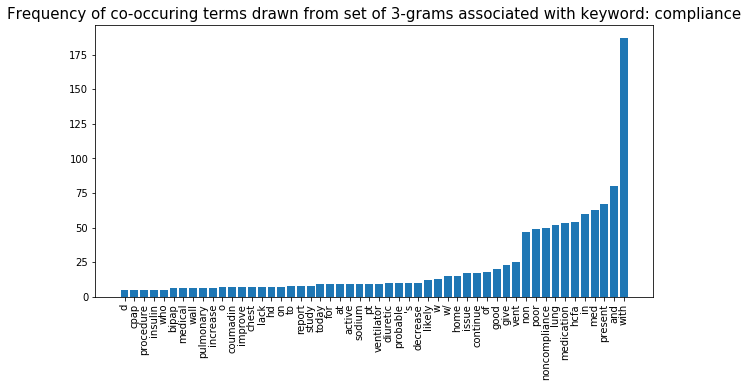

In [26]:
poor_comp_ngrams_df = pd.read_csv(ngrams_result_poor_compliance['intermediate_results_csv'])
view_n_gram_terms(poor_comp_ngrams_df, "compliance", min_apperances=5, n=3)  

### 5. Examine how useful our term sets are for finding notes we might be interested in

In addition to examining n-grams to understand term co-occurrence patterns, we can also examine the distribution of terms from our specified lists among the 'truth values' derived from extracted text. When ClarityNLP returns a document set, the results csv will contain a column labelled 'term'; this column will contain the term(s) from the term-set you passed in that caused ClarityNLP to consider the note in question a match for the criteria you specified.

Examining term counts can help us understand where the majority of our matches are coming from. If/when the distribution of these counts are skewed, we can also remove terms from the tail of the distribution, which will help to reduce query runtime. 

Note that we've handled case sensitivity here by lower-casing all terms; terms may appear with capitalization and/or in all-caps in the raw text. 

In [10]:
def plot_term_counts(results_csv, to_lowercase = True):
    
    results_df = pd.read_csv(results_csv)
    
    if to_lowercase:
        results_df['term'] = [x.lower() for x in results_df['term']]
        
    term_counts = results_df.groupby(['term']).count()['_id'].reset_index().sort_values(by=['_id'], ascending=False)
    term_counts.plot(kind='bar', x='term', y='_id')
    plt.show()
    

#### 5.1 Homelessness term counts

/Users/cherlihy3/anaconda3/envs/health_nlp_py35/lib/python3.5/site-packages/matplotlib/legend.py:592: UserWarning: The handle <BarContainer object of 8 artists> has a label of '_id' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


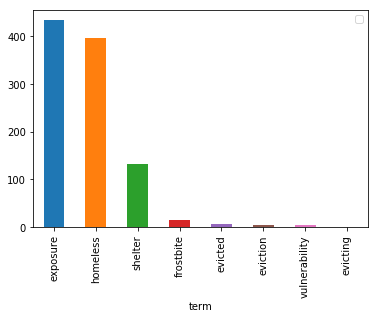

In [16]:
plot_term_counts(run_result_homeless['main_results_csv'], to_lowercase=True)

#### 5.2 Insomnia term counts

/Users/cherlihy3/anaconda3/envs/health_nlp_py35/lib/python3.5/site-packages/matplotlib/legend.py:592: UserWarning: The handle <BarContainer object of 9 artists> has a label of '_id' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


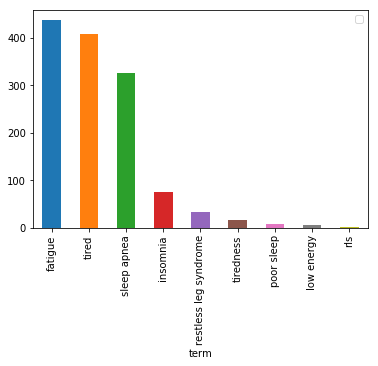

In [27]:
plot_term_counts(run_result_insomnia['main_results_csv'], to_lowercase=True)

#### 5.3 Poor medication compliance term counts

/Users/cherlihy3/anaconda3/envs/health_nlp_py35/lib/python3.5/site-packages/matplotlib/legend.py:592: UserWarning: The handle <BarContainer object of 6 artists> has a label of '_id' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


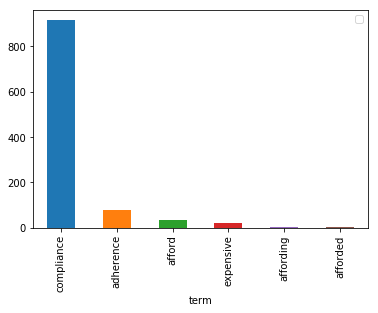

In [28]:
plot_term_counts(run_result_poor_compliance['main_results_csv'], to_lowercase=True)

### 6. Topic Modeling

Broadly speaking, **topic modeling** refers to a set of unsupervised methods for discovering/extracting latent semantic structure from a corpus. By unsupervised, we mean that in general, these models are used in situations where we do not have pre-defined labels (e.g., no one has reviewed our patient notes and placed them into thematic buckets for us), but are instead interested in mining a set of documents in order to gain insight into whatever sort of patterns/themes might exist. 

Researchers have developed several different algorithms for topic modeling; two of the main ones are **Latent Dirichlet Allocation (LDA)** and **Non-Negative Matrix Factorization (NMF)**. 

- LDA can be thought of as a generative, probabalistic approach, in which documents are modeled as mixtures over an underlying (latent) set of topics; these topics in turn are probability distributions over words; the statistical model underlying these distributions formalizes the intuitive assumption that these distributions are likely to be skewed (e.g., for any given topic, only a small set of words will be highly probable, and many other words will have probabilities close to 0). 


- NMF is a matrix factorization algorithm where we try to approximate a large matrix, X, into the product of two smaller matrices, WH, such that X ~ WH. When NMF is applied to topic modeling, the large matrix that we start with is our document-term matrix (e.g., each row represents a document; the columns represent words in the vocabulary, and the values in each cell represent some sort of term frequency matrix (e.g., raw counts; tf-idf, etc.). We factor this matrix into a doc-topic matrix and a topic-term matrix.

If you're interested in reading more, you can check out these foundational papers, and blogs:
- LDA: http://jmlr.csail.mit.edu/papers/v3/blei03a.html
- NMF for topic modeling: https://www.cc.gatech.edu/~hpark/papers/nmf_book_chapter.pdf
- Additional blogs:
    - http://mlexplained.com/2017/12/28/a-practical-introduction-to-nmf-nonnegative-matrix-factorization/
    - We'll update this with a few more helpful resources shortly.

Note that the number of topics, as well as the number of terms per topic, are parameters that must be specified by the user. There are information-theoretic approaches to choosing the optimal number of topics that are out of scope for our purposes today, but may be discussed/integrated into ClarityNLP in the future. 


In [20]:
def gen_textacy_corpus(results_df, corpus_name):
    
    corpus = textacy.Corpus(lang='en_core_web_sm')
    
    for i, row in results_df.iterrows():
        clean_remark = str(row['sentence'].encode('utf-8'))
        
        clean_remark = textacy.preprocess.preprocess_text(clean_remark, fix_unicode=False, lowercase=True, 
                transliterate=False, no_urls=False, no_emails=False, no_phone_numbers=False, 
                no_numbers=True, no_currency_symbols=False,
                no_punct=True, no_contractions=True, no_accents=False)
        
        meta_data = {
                'solr_id':row['solr_id'],
                'report_id':row['report_id'],
                'report_type':row['report_type'],  
                'subject':row['subject'],  
        }
        
        doc = textacy.Doc(clean_remark, metadata=meta_data,  lang='en_core_web_sm')
        corpus.add_doc(doc)
    
    print("Pickling corpus...")
    corpus.save("{}.pkl".format(corpus_name))
    print("Corpus created; pickled as: {}.pkl".format(corpus_name))
    return 

In [21]:
def train_and_pickle_topic_model(corpus, model_name, n_topics=10):
    
    unigram_terms_list = (doc.to_terms_list(ngrams=1, named_entities=False, as_strings=True) for doc in corpus)
    vectorizer = textacy.vsm.Vectorizer(tf_type='linear', apply_idf=True, apply_dl=True, min_df=2, max_df=0.95)
    unigram_doc_term_matrix = vectorizer.fit_transform(unigram_terms_list)
    
    num_topics = n_topics
    model = textacy.tm.TopicModel('nmf', n_topics=n_topics)
    
    model.fit(unigram_doc_term_matrix)
    model.save("./{}.pkl".format(model_name))
    
    return model

In [22]:
def load_and_apply_pkled_model(corpus, model, num_topics=10, terms_per_topic=15):
    
    unigram_terms_list = (doc.to_terms_list(ngrams=1, named_entities=False, as_strings=True) for doc in corpus)
    vectorizer = textacy.vsm.Vectorizer(tf_type='linear', apply_idf=True, apply_dl=True, min_df=2, max_df=0.95)
    unigram_doc_term_matrix = vectorizer.fit_transform(unigram_terms_list)

    doc_topic_matrix = model.transform(unigram_doc_term_matrix)
    
    topic_word_vectors = OrderedDict()
    
    for topic_idx, top_terms in model.top_topic_terms(vectorizer.id_to_term, topics=range(num_topics), top_n=terms_per_topic):
        print('topic', topic_idx, ':', " ".join(top_terms))
        
        topic_word_vectors[topic_idx] = [x for x in top_terms]

        
    return doc_topic_matrix, unigram_doc_term_matrix, topic_word_vectors

#### 6.1 Topic modeling of notes associated with patients that may be experiencing homelessness 

In [23]:
homelessness_df = pd.read_csv("http://18.220.133.76:5000/job_results/486/phenotype")
print(homelessness_df.shape)
gen_textacy_corpus(homelessness_df, "./homelessness_corpus")

(1273, 24)
Pickling corpus...
Corpus created; pickled as: ./homelessness_corpus.pkl


In [29]:
homelessness_corpus = textacy.Corpus.load("./homelessness_corpus.pkl")
print("Homelessness corpus contains {} sentences.".format(homelessness_corpus.n_docs))

Homelessness corpus contains 1273 sentences.


In [30]:
homelessness_model = train_and_pickle_topic_model(homelessness_corpus, "homelessness_model", n_topics=10)

In [31]:
# Notes:
# Topic 1: reasons why homeless patients might be compelled to seek shelter/present for treatment 
# Several of these topics contain references to several vulnerable sub-populations 
# (e.g., veterans (Topic 2); people with substance abuse issues (Topics 3;4;5); 
# people with mental health issues (Topic 6))

h_doc_topic_matrix, h_unigram_doc_term_matrix, h_topic_word_vecs = load_and_apply_pkled_model(homelessness_corpus, 
                                                                                              homelessness_model, 
                                                                                              num_topics=10, 
                                                                                              terms_per_topic=10)

topic 0 : number f cad copd p avr cabg hospital3 s fib
topic 1 : ice storm chair loose heat go y woman unresponsive o
topic 2 : stay power home shelter report veteran state inn safe address
topic 3 : pt homeless live shelter location social street un currently drinker
topic 4 : hospital abuse o h etoh hepatitis homeless alcohol shock 45yo
topic 5 : level function previous alcoholic homeless > alcohol admit bili light
topic 6 : seizure patient witness bed shelter find homeless ed disorder state
topic 7 : overdose intentional insulin year old man dm1 admit homeless number
topic 8 : number exposure prenatal ga ex hospital1 wk multiple infant anticonvulsant
topic 9 : occasionally tightness develop v hrs n w chest pt homeless


#### 6.2 Topic modeling of notes associated with patients that may be experiencing insomnia

In [32]:
insomnia_df = pd.read_csv("http://18.220.133.76:5000/job_results/487/phenotype")
print(insomnia_df.shape)
gen_textacy_corpus(insomnia_df, "./insomnia_corpus")

(1468, 24)
Pickling corpus...
Corpus created; pickled as: ./insomnia_corpus.pkl


In [33]:
insomnia_corpus = textacy.Corpus.load("./insomnia_corpus.pkl")
print("Insomnia corpus contains {} sentences.".format(insomnia_corpus.n_docs))

Insomnia corpus contains 1468 sentences.


In [34]:
insomnia_model = train_and_pickle_topic_model(insomnia_corpus, "insomnia_model", n_topics=10)

In [35]:
# Notes:
# Topic 4: Related to sleep apnea and associated medical devices
# Topic 6: Related to cardiac/respiratory conditions
# Topic 9: Related to anxiety and associated pharmaceutical treatments

i_doc_topic_matrix, i_unigram_doc_term_matrix, i_topic_word_vecs = load_and_apply_pkled_model(insomnia_corpus, 
                                                                                              insomnia_model, 
                                                                                              num_topics=10, 
                                                                                              terms_per_topic=10)

topic 0 : osa obstructive apnea sleep h monitor cult egd follow consult
topic 1 : number s p sat low pain o2 varix chronic etoh
topic 2 : leg restless syndrome crohns pt history d problem fentanyl deficiency
topic 3 : w osh lymphoma initially find high hypothyroidism grade insomnia present
topic 4 : sleep apnea pt cpap bipap hx patient night sat action
topic 5 : tired m today state feel day pt o car extremely
topic 6 : old chf yesterday year present fatigue male history copd mental
topic 7 : csa central apnea sleep h sodium level likely pause dni
topic 8 : o c h tiredness note sob oob fatigue commode maintain
topic 9 : mg overnight sleeplessness ativan liter effect number anxiety po 2


#### 6.3 Topic modeling of notes associated with patients that may be exhibiting poor medication compliance

In [36]:
poor_compliance_df = pd.read_csv("http://18.220.133.76:5000/job_results/488/phenotype")
print(poor_compliance_df.shape)
gen_textacy_corpus(poor_compliance_df, "./poor_compliance_corpus")

(951, 24)
Pickling corpus...
Corpus created; pickled as: ./poor_compliance_corpus.pkl


In [37]:
poor_compliance_corpus = textacy.Corpus.load("./poor_compliance_corpus.pkl")
print("Poor compliance corpus contains {} sentences.".format(poor_compliance_corpus.n_docs))

Poor compliance corpus contains 951 sentences.


In [38]:
poor_compliance_model = train_and_pickle_topic_model(poor_compliance_corpus, "poor_compliance_model", n_topics=10)

In [39]:
# Notes:
# Topics contain mentions of out-patient/external settings where compliance may become an issue (e.g., home (Topic 2;5))
# Topic 3 relates to drug and non-drug related forms of non-compliance (e.g., diet; sodium intake) that require
#         patient education/reinforcement 
# Topic 6 relates to affordability of medication 

# Note that relative to other phenotypes we've covered, there's more breadth here. That makes sense because
# compliance is a broader umbrella topic. We could consider ways to hone in on specific instances in the future. 

pc_doc_topic_matrix, pc_unigram_doc_term_matrix, pc_topic_word_vecs = load_and_apply_pkled_model(poor_compliance_corpus, 
                                                                                                 poor_compliance_model,
                                                                                                 num_topics=10, 
                                                                                                 terms_per_topic=10)

topic 0 : number peep pressure plateau cc = plat abg ef patient
topic 1 : compliance vent lung increase remain improve sedate pt decrease propofol
topic 2 : antianxiety bipap m add return help option home discuss compliance
topic 3 : diet sodium restriction medication response discuss importance daily replete educate
topic 4 : continue failure renal acute monitor titrate sedation arf vent current
topic 5 : expensive service decline vna home hospital pt variety number ccu
topic 6 : medication non afford pt adherence care recent poor patient ni
topic 7 : cellulitis copd 74yo hypoxia hypercarbia medical le depression f hx
topic 8 : med compliance discharge non change need past variety ccu team
topic 9 : w effect gtt d c change bp start agitation htn


### 7. Topic assignment and visualization

Once we have run topic modeling for a given phenotype, we can use the **document-topic matrix** that is output our `load_and_apply_pkled_model` function to assign documents to topic(s). 

Each row in this matrix represents a document, and the columns represent topics; thus, this is a `num_documents*num_topics`-shaped matrix. When NMF is used, a document (e.g., row) can be thought of as a weighted sum over the topics; Thus, we can argmax this vector to get the topic (set of terms) that is most representative of the document in question. 

We can use this step to assign topic(s) to notes, and consider/visualize the distribution of topics in our corpus as a whole, and/or within and among different sub-groups, such as gender, age, race/ethnicity, comorbidity status, etc. We can also use our corpus metadata to link back to structured datat that may be of interest (e.g., MIMIC). We can then plot a lower-dimensional representation of our notes by topic, while simultaneously highlighting structured features of interest. This can help us to discover how different characteristics of our patient population intersect. 

In [40]:
def assign_doc_to_topics(n_topics_per_doc, document_topic_matrix, corpus, model, weights=False):

    doc_topics_list = list(model.top_doc_topics(document_topic_matrix, docs=(-1), top_n=n_topics_per_doc, weights=weights))
    
    # Greedy assignment; we're essentially taking the argmax of each vector 
    for i,doc in enumerate(corpus):
        corpus[i].metadata['topic_vec'] = doc_topics_list[i][1][0]
        
    return corpus

In [41]:
def visualize_distribution_over_topics(corpus_with_topics, topic_vectors, corpus_name, field_to_group_by = None):
    
    topics = [doc.metadata['topic_vec'] for doc in corpus_with_topics]
    topics_with_counts = Counter(topics)

    labels = ['Topic {} (n= {}; {}%): {}'.format(k,
                                                 topics_with_counts[k], 
                                                 int(round((topics_with_counts[k]/corpus_with_topics.n_docs)*100, 0)), 
                                                 v) for k, v in topic_vectors.items()]
    pd.DataFrame(pd.Series(topics_with_counts)/corpus_with_topics.n_docs).T.plot.bar(stacked=True, figsize=(7, 5))
    plt.legend(labels, bbox_to_anchor=(1.05, 0.95))
    plt.title("Distribution over topics for {} corpus (greedy assignment; n=1; corpus size={})".
              format(corpus_name,corpus_with_topics.n_docs), fontsize=15)
    

#### 7.1 Topic assignment and visualization for patients potentially experiencing homelessness

In [42]:
homelessness_corpus_w_topics  = assign_doc_to_topics(1, h_doc_topic_matrix, homelessness_corpus, homelessness_model)

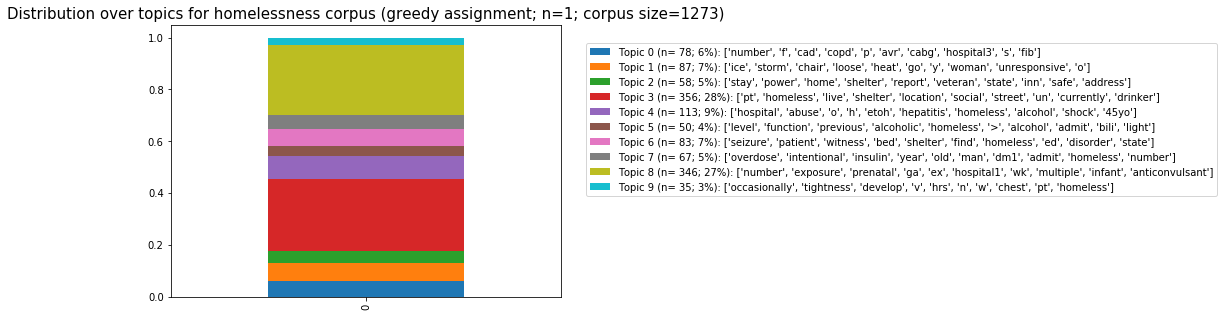

In [43]:
# Notice the heavy presence of topic 8 (this reflects in part that MIMIC is our data source, and also reflects
# the fact that mothers/infants are arguably more likely to receive social services than the general homeless population)

visualize_distribution_over_topics(homelessness_corpus_w_topics, h_topic_word_vecs, "homelessness", field_to_group_by = None)

#### 7.2 Topic assignment and visualization for patients potentially experiencing insomnia

In [44]:
insomnia_corpus_w_topics  = assign_doc_to_topics(1, i_doc_topic_matrix, insomnia_corpus, insomnia_model)

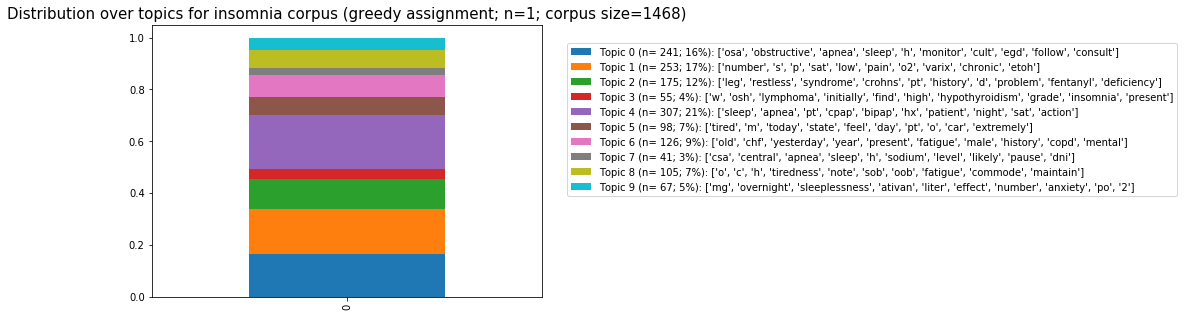

In [45]:
# Here, we see heavy dominance of topics 0 and topic 4, both of which are related to sleep apnea.

visualize_distribution_over_topics(insomnia_corpus_w_topics, i_topic_word_vecs, "insomnia", field_to_group_by = None)

#### 7.3 Topic assignment and visualization for patients potentially exhibiting poor medication compliance

In [46]:
poor_compliance_corpus_w_topics  = assign_doc_to_topics(1, pc_doc_topic_matrix, poor_compliance_corpus, poor_compliance_model)

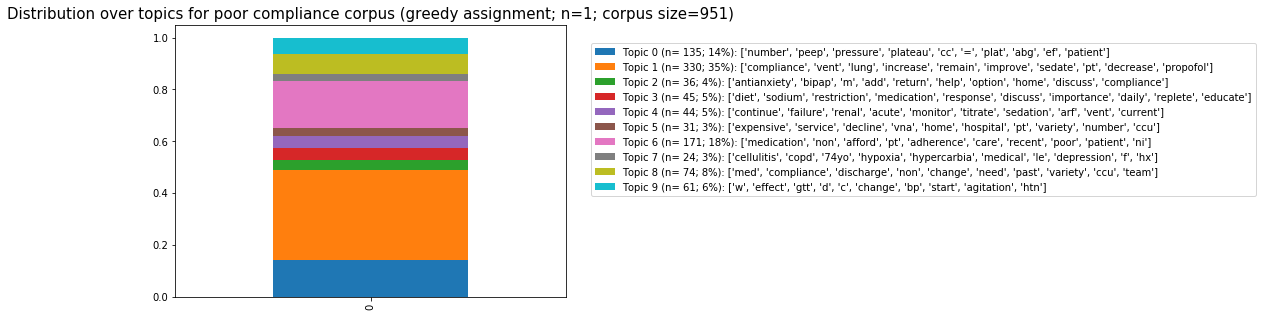

In [48]:
# Here, notice that topic 6 is heavily represented; this topic is about affordability of medication.

visualize_distribution_over_topics(poor_compliance_corpus_w_topics, pc_topic_word_vecs, "poor compliance", field_to_group_by = None)

#### 8.1 Visualize by demographics

In this section, we call a helper function that lets us link our patients returned by our NLPQl queries (with their topic assignments) to underlying structured data in MIMIC. This is possible because we have an OMOP instance of the MIMIC dataset, and are able to link on `person_id`. This can be implemented at your site with minor adjustments to the underlying config file to ensure it is pointed at the correct database. The query we have passed in for demonstration purposes is very simple, but could easily be modified to return more complex features, including patient-level diagnoses, medications, observations, and procedures.

We've designed a set of helper functions to plot demographic information along with topic information:

In [49]:
def plot_demographics(demographics_df, domain, topic=''):

    race_counts = demographics_df.groupby(['race']).count()['subject'].reset_index().sort_values(by=['subject'], ascending=False)
    race_counts.plot(kind='bar', x='race', y='subject')
    topic_label=''
    if len(topic) > 0:
        topic_label = ' on topic {}'.format(str(topic))
    plt.title('Race counts on {} corpus {}'.format(domain, topic_label))
    plt.show()
    
    gender_counts = demographics_df.groupby(['gender']).count()['subject'].reset_index().sort_values(by=['subject'], ascending=False)
    gender_counts.plot(kind='bar', x='gender', y='subject')
    topic_label=''
    if len(topic) > 0:
        topic_label = ' on topic {}'.format(str(topic))
    plt.title('Gender counts on {} corpus {}'.format(domain, topic_label))
    plt.show()


In [59]:
from claritynlp_notebook_helpers import query_patients
homelessness_patients = set([doc.metadata['subject'] for doc in homelessness_corpus])
print("There are {} unique homeless patients.".format(len(homelessness_patients)))
# homeless_patients_demographics = pd.DataFrame(query_patients(list(homelessness_patients)))
# homeless_patients_demographics.head()

There are 324 unique homeless patients.


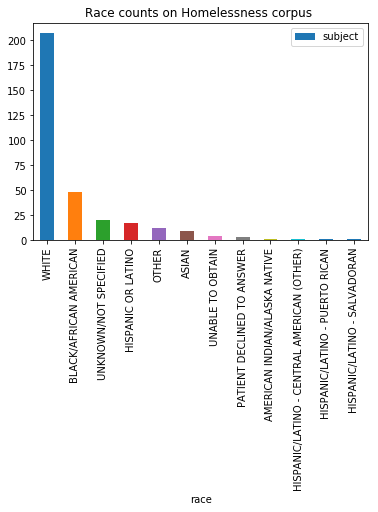

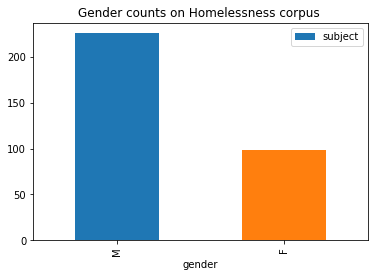

In [68]:
plot_demographics(homeless_patients_demographics, 'Homelessness')

In [60]:
insomnia_patients = set([doc.metadata['subject'] for doc in insomnia_corpus])
print("There are {} unique insomnia patients.".format(len(insomnia_patients)))
# insomnia_demographics = pd.DataFrame(claritynlp.query_patients(list(insomnia_patients)))
# insomnia_demographics.head()

There are 459 unique insomnia patients.


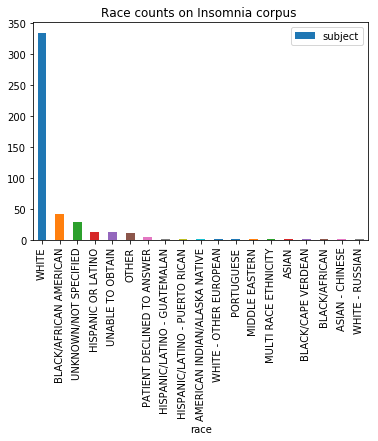

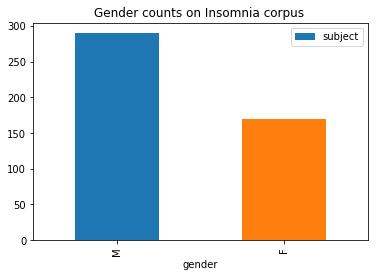

In [69]:
plot_demographics(insomnia_demographics, 'Insomnia')

In [61]:
poor_compliance_patients = set([doc.metadata['subject'] for doc in poor_compliance_corpus])
print("There are {} unique poor compliance patients.".format(len(poor_compliance_patients)))
# poor_compliance_demographics = pd.DataFrame(claritynlp.query_patients(list(poor_compliance_patients)))
# poor_compliance_demographics.head()

There are 533 unique poor compliance patients.


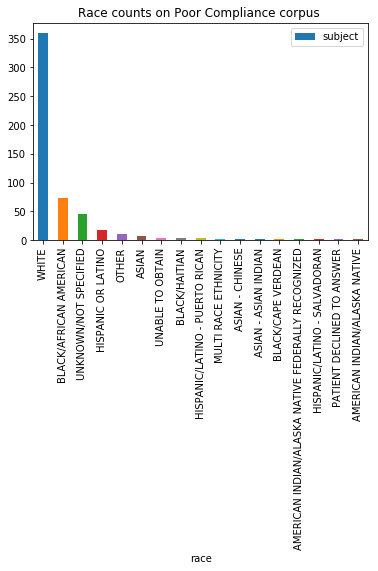

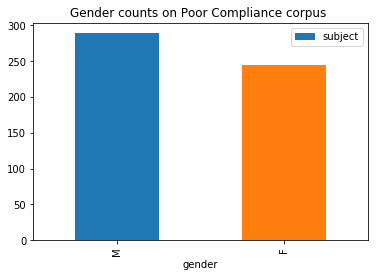

In [70]:
plot_demographics(poor_compliance_demographics, 'Poor Compliance')

#### 8.1 Visualize by demographics + Topic

In [123]:
def plot_by_topic(corpus, domain, topic):
    patients = list()
    # this didn't work with lambdas, will retry later
    for doc in corpus:
        if doc.metadata['topic_vec'] == topic:
            patients.append(doc.metadata['subject'])
    print("There are {} unique {} patients in topic {}.".format(len(patients), domain, topic))
    if len(patients) > 0:
        patients_demographics = pd.DataFrame(claritynlp.query_patients(list(patients)))
        patients_demographics.head()
        plot_demographics(insomnia_demographics, domain, topic=str(topic))



There are 113 unique Homelessness patients in topic 4.


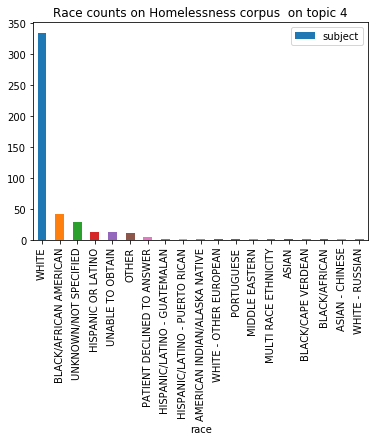

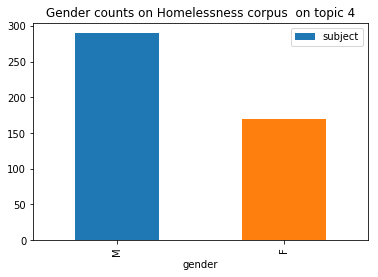

In [124]:
plot_by_topic(homelessness_corpus, 'Homelessness', 4)

There are 241 unique Insomnia patients in topic 0.


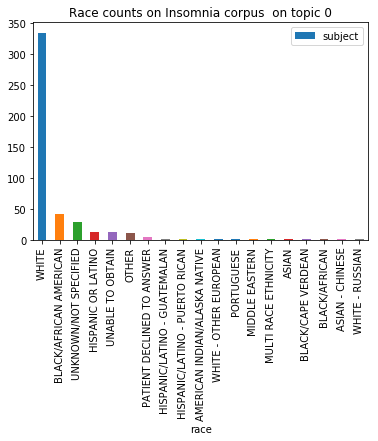

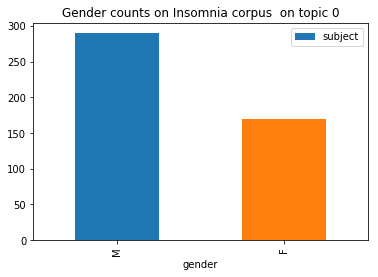

In [125]:
plot_by_topic(insomnia_corpus, 'Insomnia', 0)

There are 330 unique Poor Complaine patients in topic 1.


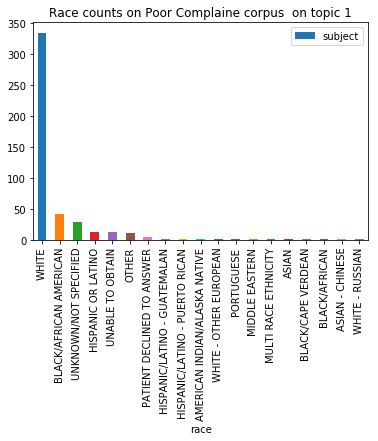

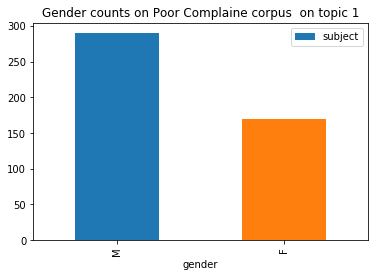

In [127]:
plot_by_topic(poor_compliance_corpus, 'Poor Complaine', 1)